In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [30]:
# Load the image in grayscale
def load_image(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image not found: {file_path}")
    return image

# File paths for images
image_names = ["camera.png", "coins.png", "page.png", "rocksample.png", "star_wars.jpg"]
images = [load_image(img) for img in image_names]

libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent


In [15]:
def kmeans_segmentation(image, k):
    # Flatten the image for k-means
    flat_image = image.flatten().reshape(-1, 1)
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(flat_image)
    segmented = kmeans.labels_.reshape(image.shape)
    # Normalize the segmented image for display
    segmented = (segmented / (k - 1) * 255).astype(np.uint8)
    return segmented

In [16]:
def otsu_thresholding(image):
    _, thresholded = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresholded

In [ ]:
def denoise_segmentation(image, neighborhood=4, threshold=0.5, iterations=1):
    padded_image = np.pad(image, 1, mode='constant', constant_values=0)
    result = image.copy()
    height, width = image.shape

    # Define neighbor offsets
    if neighborhood == 4:
        offsets = [(0, -1), (-1, 0), (0, 1), (1, 0)]
    elif neighborhood == 8:
        offsets = [(0, -1), (-1, 0), (0, 1), (1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]
    else:
        raise ValueError("Neighborhood must be 4 or 8")

    for _ in range(iterations):  # Apply multiple iterations
        temp_result = result.copy()
        padded_image = np.pad(temp_result, 1, mode='constant', constant_values=0)  # Update padding
        
        for i in range(1, height + 1):
            for j in range(1, width + 1):
                # Collect neighbor labels
                neighbors = [
                    padded_image[i + dx, j + dy]
                    for dx, dy in offsets
                ]
                # Count votes for each label
                votes = np.bincount(neighbors, minlength=256)
                majority_label = np.argmax(votes)
                majority_ratio = votes[majority_label] / len(neighbors)
                
                # Update label if it passes the threshold
                if majority_ratio >= threshold:
                    temp_result[i - 1, j - 1] = majority_label

        result = temp_result  # Update result for the next iteration

    return result

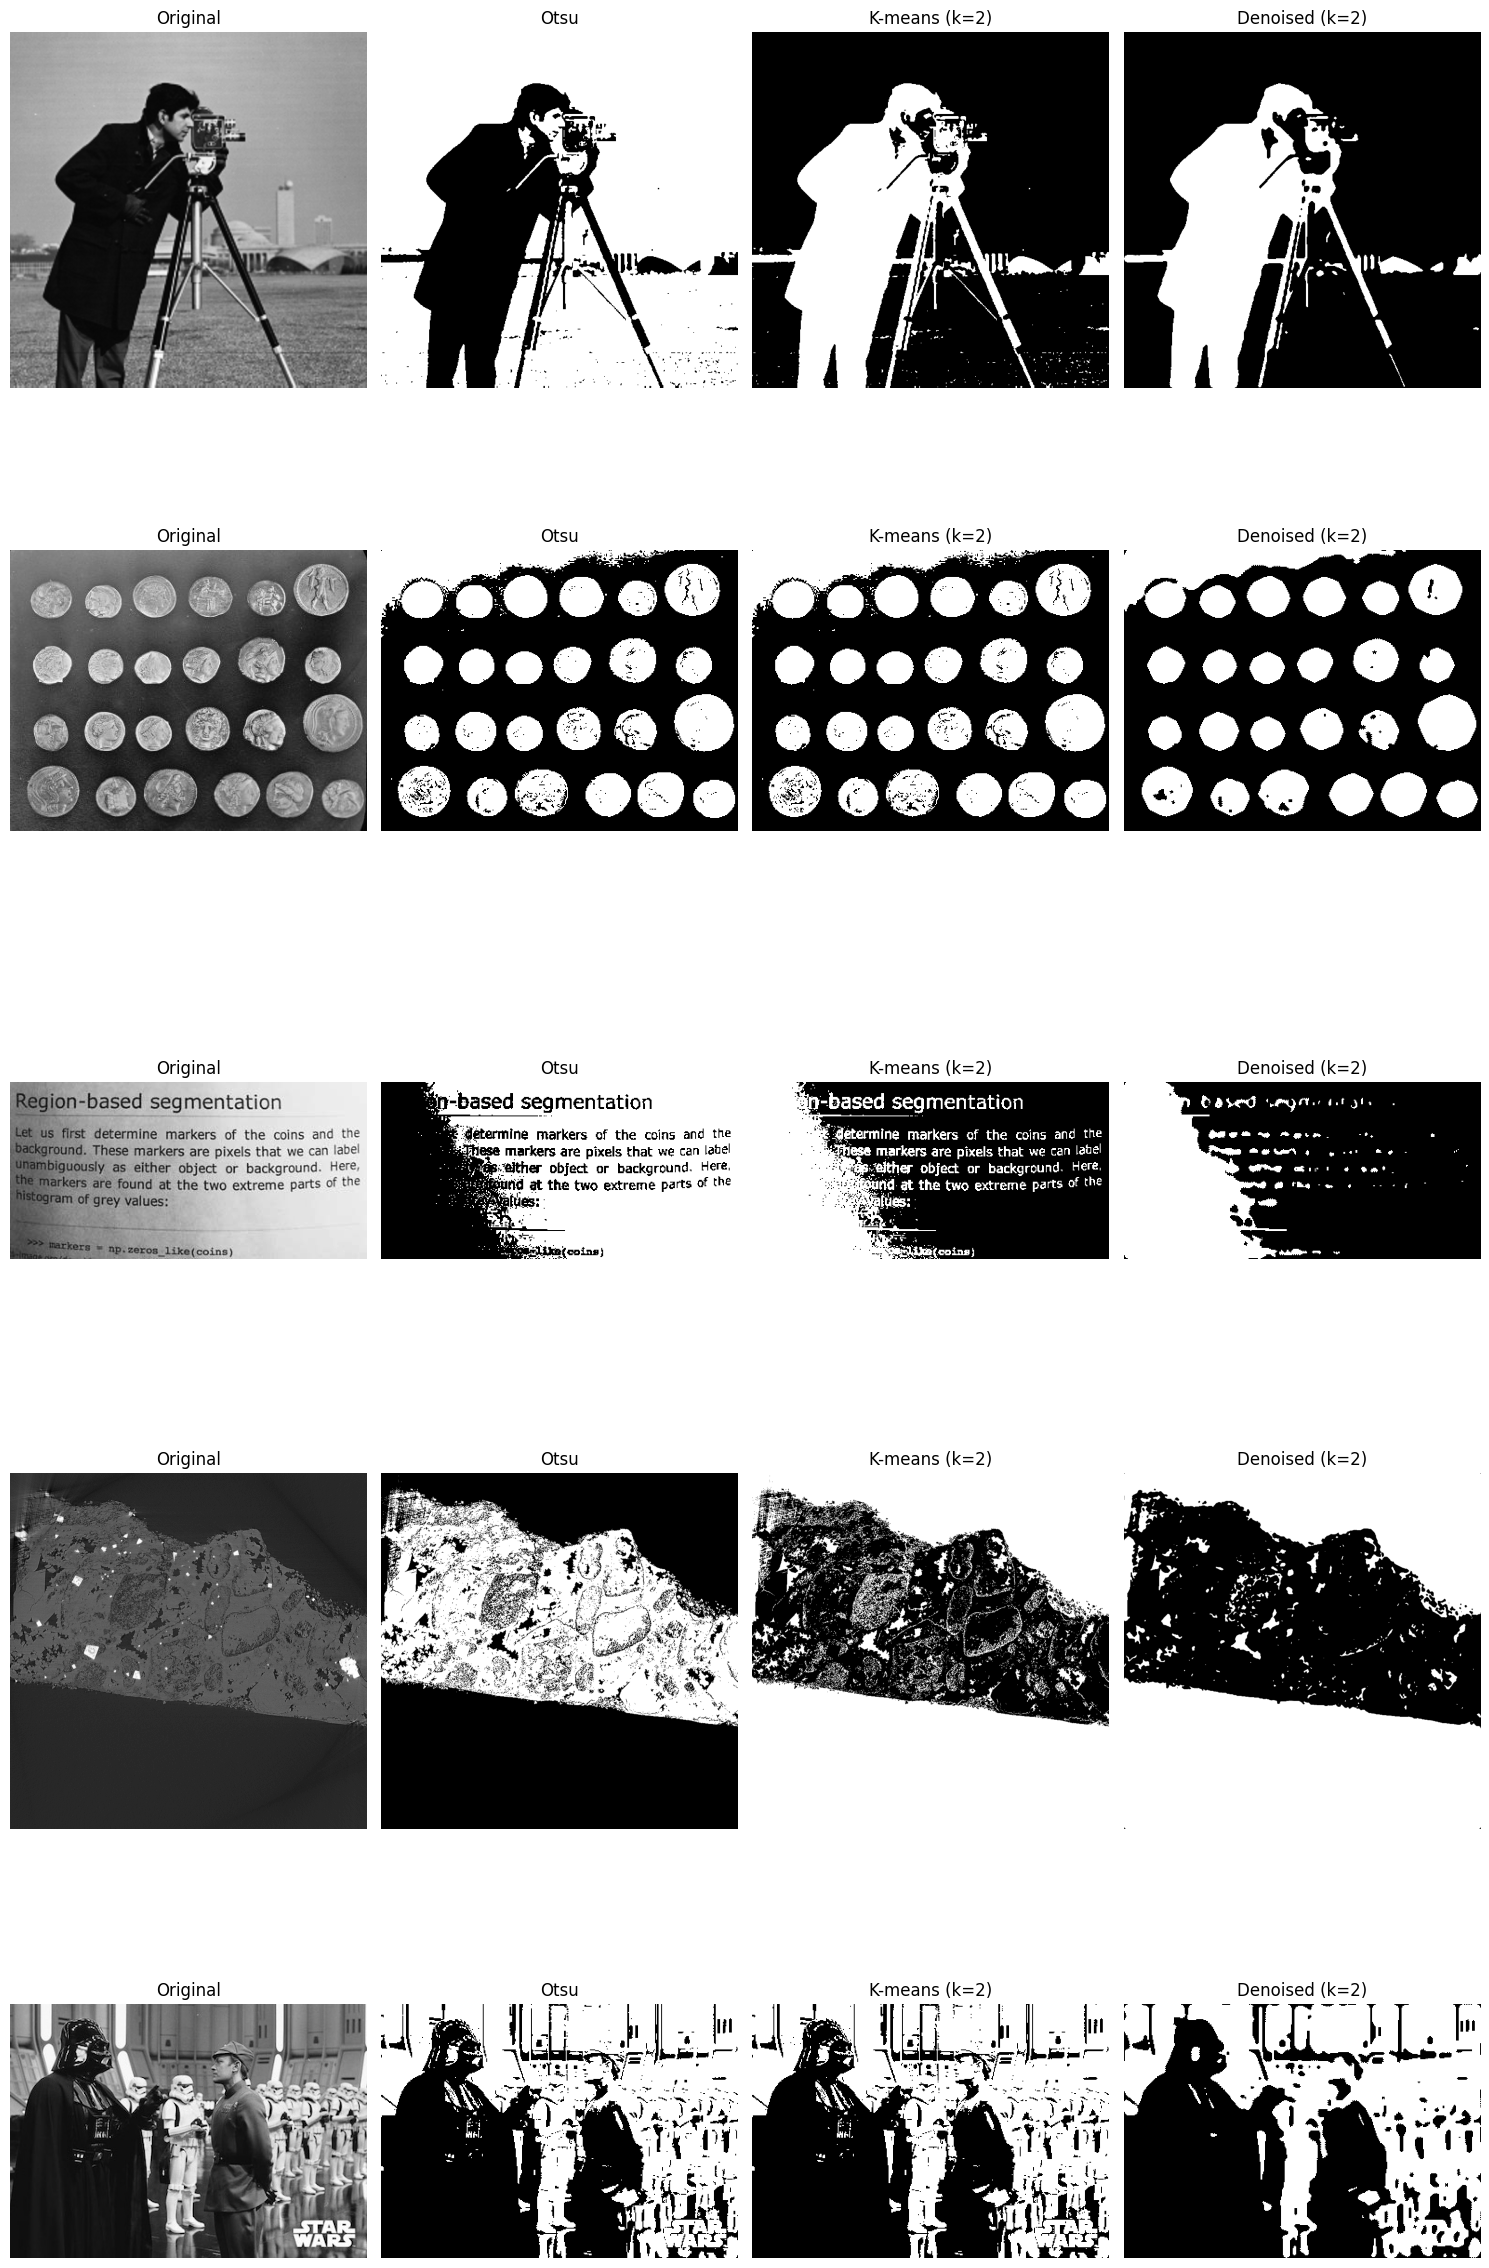

In [33]:
fig, axs = plt.subplots(5, 4, figsize=(15, 25))
k=2
    
for i, (image, name) in enumerate(zip(images, image_names)):
    # Original image
    axs[i, 0].imshow(image, cmap='gray')
    axs[i, 0].set_title("Original")
    axs[i, 0].axis('off')
    
    # Denoised result
    otsu_segmented = otsu_thresholding(image)
    axs[i, 1].imshow(otsu_segmented, cmap='gray')
    axs[i, 1].set_title("Otsu")
    axs[i, 1].axis('off')

    # K-means segmentation
    kmeans_segmented = kmeans_segmentation(image, k)
    axs[i, 2].imshow(kmeans_segmented, cmap='gray')
    axs[i, 2].set_title(f"K-means (k={k})")
    axs[i, 2].axis('off')

    denoised_image = denoise_segmentation(kmeans_segmented, neighborhood=4, threshold=0.5, iterations=4)
    axs[i, 3].imshow(denoised_image, cmap='gray')
    axs[i, 3].set_title(f"Denoised (k={k})")
    axs[i, 3].axis('off')

plt.tight_layout()
plt.show()

libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent


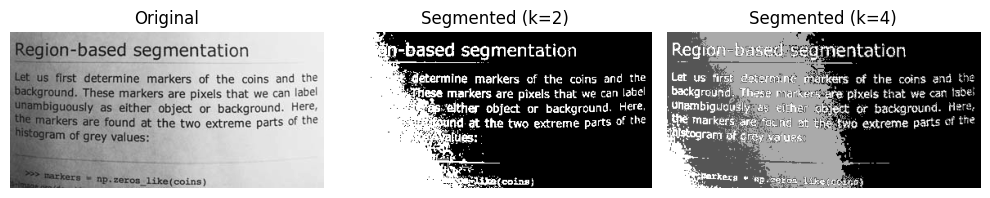

In [29]:
# Apply k-means with k=4

page_image = load_image("page.png")
segmented_k2 = kmeans_segmentation(page_image, 2)
segmented_k4 = kmeans_segmentation(page_image, 4)
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(page_image, cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')
axs[1].imshow(segmented_k2, cmap='gray')
axs[1].set_title("Segmented (k=2)")
axs[1].axis('off')
axs[2].imshow(segmented_k4, cmap='gray')
axs[2].set_title("Segmented (k=4)")
axs[2].axis('off')
plt.tight_layout()
plt.show()